In [1]:
import disentangler as dt
from disentangler.dependencies import *

In [2]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

In [3]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_NO_DISENTANGLEMENT+'2')

mira_model.predict(rna_data)
mira_model.get_batch_effect(rna_data)
mira_model.impute(rna_data)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


from tqdm.notebook import tqdm

corrs = {}
for i in tqdm(range(rna_data.n_vars)):
    corrs[rna_data.var_names[i]] = \
        np.corrcoef(rna_data.layers['imputed'][:,i], rna_data.layers['batch_effect'][:,i])[0,1]

rna_data.var = rna_data.var.drop(columns = ['entanglement'])

rna_data.var = rna_data.var.join(pd.Series(corrs, name = 'entanglement'), how = 'left')

rna_data.var[(rna_data.var.dispersions_norm > 0.5) & (rna_data.var.mean_counts > 0.5) & rna_data.var.entanglement > .7]\
    .sort_values('entanglement').tail(50).index.values

In [4]:
def entanglement_panel(adata, ax, gene):

    dt.plots.disentanglement_plot(adata, 
        ax[0], gene, 
        palette = sns.color_palette('light:blue', as_cmap=True), 
        size = 1)

    dt.plots.disentanglement_plot(adata, ax[1], gene, 
        color = 'cell_type', 
        palette = list(dt.bonemarrow.colors.CELL_PALETTE.values()), 
        add_legend=False,
        hue_order = list(dt.bonemarrow.colors.CELL_PALETTE.keys()), size = 1)

    dt.plots.disentanglement_plot(adata, ax[2], gene, 
        color = 'batch', 
        palette = list(dt.bonemarrow.colors.BATCH_PALETTE.values()),
        add_legend=False,
        hue_order = list(dt.bonemarrow.colors.BATCH_PALETTE.keys()), 
        size = 1)

    for _ax in np.ravel(ax):
        _ax.set(ylabel = '', yticks = [], xticks = [0], xlabel = '')

    ax[0].set_title(gene)
    ax[1].set_title(None)
    ax[2].set_title(None)

    plt.tight_layout()
    
    return ax

In [5]:
# MGAT5, 

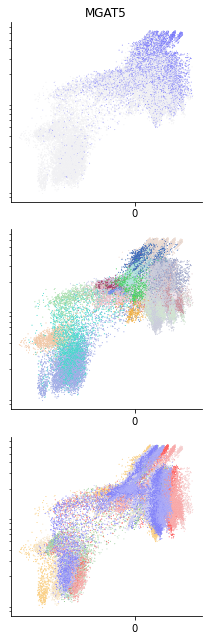

In [6]:
fig, ax = plt.subplots(3,1,figsize=(3,9))
entanglement_panel(rna_data, ax, 'MGAT5')
plt.savefig('figure1/marginal_panels/entangled_MGAT5.png')

In [7]:
!mkdir -p figure1/marginal_panels/

fig, ax = plt.subplots(3,1,figsize=(3,9))
entanglement_panel(rna_data, ax, 'MAML2')
plt.savefig('figure1/marginal_panels/entangled_MAML2.png')

In [8]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')

mira_model.predict(rna_data)
mira_model.get_batch_effect(rna_data)
mira_model.impute(rna_data)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


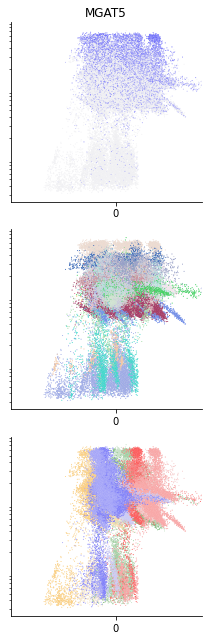

In [9]:
fig, ax = plt.subplots(3,1,figsize=(3,9), sharex=False)
ax = entanglement_panel(rna_data, ax, 'MGAT5')
for i in range(3):
    ax[i].set(xlim = (-0.8,0.65))
plt.savefig('figure1/marginal_panels/DISentangled_MGAT5.png')

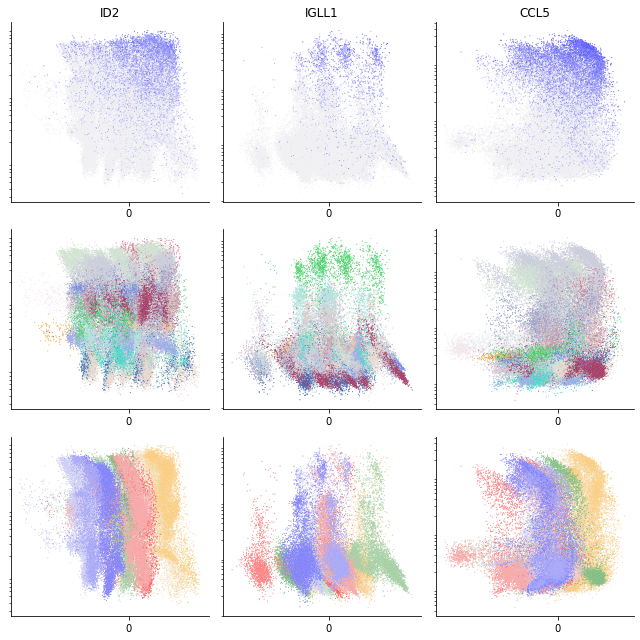

In [10]:
fig, ax = plt.subplots(3,3,figsize=(9,9))
entanglement_panel(rna_data, ax[:,0], 'ID2')
entanglement_panel(rna_data, ax[:,1], 'IGLL1')
entanglement_panel(rna_data, ax[:,2], 'CCL5')
plt.savefig('figure1/marginal_panels/disentangled_genes.png')

In [11]:
from sklearn.preprocessing import minmax_scale

In [12]:
def compare_imputation_plot(g1, g2,
                           g1_palette, g2_palette):

    fig, ax = plt.subplots(2,1,figsize=(3.5,6), sharex=True,
                          sharey=True)
    sns.scatterplot(
        ax = ax[0],
        y = rna_data.obs_vector(g1, layer = 'imputed'), 
        x = rna_data.obs_vector(g2, layer = 'imputed'),
        hue = rna_data.obs_vector('cell_type'),
        palette=list(dt.bonemarrow.colors.CELL_PALETTE.values()), 
        legend=False,
        hue_order = list(dt.bonemarrow.colors.CELL_PALETTE.keys()), 
        s = 1,
    )


    sns.scatterplot(
        ax = ax[1],
        x = rna_data.obs_vector(g2, layer = 'imputed'), 
        y = rna_data.obs_vector(g1, layer = 'imputed'),
        hue = rna_data.obs_vector(g1),
        palette= sns.color_palette(g1_palette, as_cmap=True),
        legend = False,
        s = 1,
    )

    sns.scatterplot(
        ax = ax[1],
        x = rna_data.obs_vector(g2, layer = 'imputed'), 
        y = rna_data.obs_vector(g1, layer = 'imputed'),
        hue = rna_data.obs_vector(g2),
        alpha = minmax_scale(rna_data.obs_vector(g2)),
        palette= sns.color_palette(g2_palette, as_cmap=True),
        legend = False,
        s = 1,
    )

    ax[1].set(yscale = 'log', xscale = 'log', xticks = [], yticks = [])
    sns.despine()
    plt.tight_layout()
    
    return ax
    
    #plt.savefig('figure1/MME_vs_MS4A1_imputation.png')

In [13]:
dt.bonemarrow.colors.CELL_PALETTE.keys()

dict_keys(['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'CD14+ Mono', 'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog', 'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell', 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'])

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


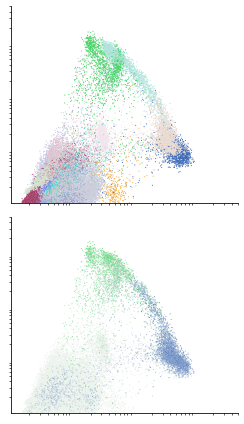

In [14]:
compare_imputation_plot('MME','MS4A1', 
                        'light:' + dt.bonemarrow.colors.CELL_PALETTE['Lymph prog'],
                        'light:' + dt.bonemarrow.colors.CELL_PALETTE['B1 B'])[0]\
    .set(xlim = (1e-5, 5e-2),ylim = (1e-5, 5e-2))

plt.savefig('figure1/MME_vs_MS4A1_imputation.png')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


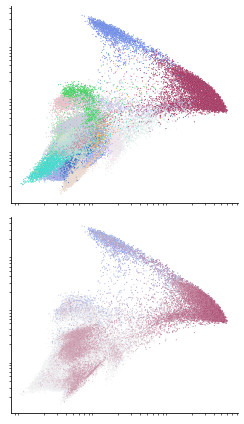

In [15]:
compare_imputation_plot('TCF7L2','VCAN', 
                        'light:' + dt.bonemarrow.colors.CELL_PALETTE['CD16+ Mono'],
                        'light:' + dt.bonemarrow.colors.CELL_PALETTE['CD14+ Mono'],)
plt.savefig('figure1/TCF7L2_vs_VCAN_imputation.png')